## 2. Simple Linear Regression Analysis

<a id='Table of Contents'></a>
### Table of Contents
1. What is linear regression?
2. <a href='#Linear Regression Line'>Linear regression line</a>
3. <a href='#Find the best fit regression line'>Find the best fit regression line</a>
4. <a href='#Prediction with linear regression'>Prediction with linear regression</a>
5. <a href='#Linear Regression Visualization'>Linear regression visualization</a>

### 1) What is linear regression?
1. Linear regression is a great tool to explain the relationship between two numeric variables using a straight line. For example, here I have two numeric variables from this data set, the percentage of ball possession and the percentage of pass accuracy. I then wonder, "what is the relationship between the ball possession and the pass accuracy?" or "How is the ball possession is related to the pass accuracy?". 
2. To answer these questions, I dot-plotted all values on the grid to get easy and quick understanding of potential correlation between two variables.

In [2]:
# Import libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno

import plotly.express as px
import plotly.graph_objects as go

import rfpimp
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

import statsmodels.formula.api as smf
from scipy import stats

C:\Users\james\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
# Define working directory
os.chdir("C:/Users/james/Desktop/Coding/Kaggle/FIFA 2018")

# Import csv file
df = pd.read_csv("FIFA 2018.csv")

In [7]:
# Fill missing values in 1st Goal with 0
df["1st Goal"].fillna(0)

# Print missing values only in both columns
og = ["Own goals", "Own goal Time"]
og_null = df.loc[df["Own goals"].isna(), og]

df.loc[og_null.index, og]
df.loc[og_null.index, og].head()

# Fill missing values with 0
df.loc[og_null.index, og].fillna(0)

,Own goals,Own goal Time
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
5,0.0,0.0
...,...,...
122,0.0,0.0
123,0.0,0.0
124,0.0,0.0
125,0.0,0.0


In [8]:
# Create a new column "Result" that contains the result of each match and add it to the dataframe

df = df.copy()

df["Result"]=np.nan
for i in range(0, 128, 2):
    a_team=df.iloc[i]['Goal Scored']
    b_team=df.iloc[i+1]['Goal Scored']
    
    if a_team > b_team:
        df.iloc[i, -1] = "win"
        df.iloc[i+1, -1] = "lose"
    elif b_team > a_team:
        df.iloc[i, -1] = "lose"
        df.iloc[i+1, -1] = "win"
    else:
        df.iloc[i, -1] = "draw"
        df.iloc[i+1, -1] = "draw"
        
df[["Result"]].head(6)

,Result
0,win
1,lose
2,lose
3,win
4,lose
5,win


In [9]:
fig = px.scatter(df, x="Ball Possession %", y="Pass Accuracy %")
fig.show()

In [10]:
# Bubble chart setting marker size and color with match results
fig = px.scatter(df, x="Ball Possession %", y="Pass Accuracy %", color="Result", size="Passes", hover_name="Team")
fig.show()

#### Observations
1. In the scatterplot above, it is noticeable that there is certain correlation between two variables as the percentage of the ball possession increases, the percentage of the pass accuracy increases as well.
2. Then, how do we assess the magnitude of the correlation between two variables? In other words, how do we quantify how much these two variables are correlated? With Pearson correlation coefficient, we can answer this question.
3. Pearson correlation coefficient is a value with the range between -1 and +1. It measures correlation between two numeric variables. It gives information about the magnitude of the association, or correlation, as well as the direction of the relationship. A value of +1 is total positive linear correlation, 0 is no linear correlation, and −1 is total negative linear correlation.

In [11]:
def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays"""
    # Compute correlation matrix: corr_mat
    corr_mat = np.corrcoef(x, y)
    
    # Return entry [0, 1]
    return corr_mat[0, 1]

# Calculate the Pearson correlation coefficient between two variables
corr_bp_pa = pearson_r(df["Ball Possession %"], df["Pass Accuracy %"])
print(round(corr_bp_pa, 2))

0.71


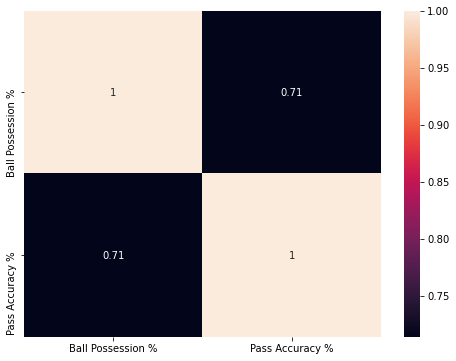

In [12]:
# Pearson's r with heatmap
corr = df[["Ball Possession %", "Pass Accuracy %"]]

plt.figure(figsize=(8, 6))
sns.heatmap(corr.corr(), annot=True)
plt.show()

#### Observations
1. If the abosolute value of Pearson's r is greater than 0.6, it is usually considered that strong correlation exists between variables. The value of 0.71 tells us that there is strong, positive, and linear correlation between those two variables.
2. Then, the followup question is "How do we describe this linear correlation between those two variables?
3. Put it simply, since they have a linear correlation, we can represent it with a linear line.
4. And this is where a linear regression line comes into play.


#### <a href='#Table of Contents'>[Move to the Table of Contents]</a>
<a id='Linear Regression Line'></a>
### 2) Linear regression line
1. The linear regression line can be expressed by an equation, Y = AX + B, where X is the explanatory variable, which in this example is Ball Possession, and Y is a dependent variable, Pass Accuracy. A is a slope that sets how steep the line is, and B is the intercept that sets where the line corsses the y-axis.
2. We can represent the relationship between those two variables with this equation. However, the problem is that there are many lines we can draw throug these scattered dots on the grid.
3. Let's see how many possible lines we can draw.

In [13]:
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)

    return bs_slope_reps, bs_intercept_reps

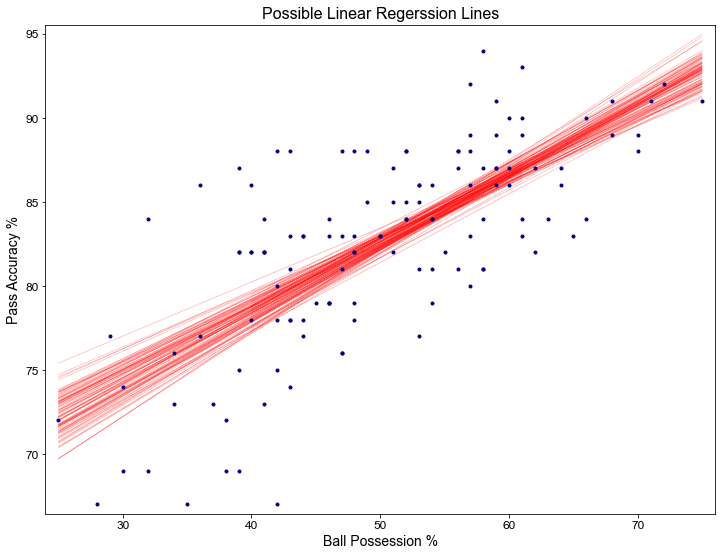

In [14]:
# Generate pair bootstrap for x, y respectively
x = df["Ball Possession %"]
y = df["Pass Accuracy %"]

bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(x, y, 100)

# Plot the bootstrap lines
plt.figure(figsize=(12, 9))
for i in range(100):
    plt.plot(x, bs_slope_reps[i]*x + bs_intercept_reps[i], linewidth=0.5, alpha=0.2, color='red')

# Plot the data
sns.set_style("darkgrid")
plt.plot(df["Ball Possession %"], df["Pass Accuracy %"], color='navy', marker='.', linestyle='none')

# Label axes, set the margins, and show the plot
plt.xlabel('Ball Possession %', fontsize=14)
plt.ylabel('Pass Accuracy %', fontsize=14)
plt.title('Possible Linear Regerssion Lines', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.margins(0.02)
plt.show()

#### Observations
1. These lines are bootstrapping linear regression lines, meaning that I drew those lines from 100 resampled data, called bootstrap samples, from the original data.
2. Graphically, we can confirm that there can be lots of possible linear regression lines. 
    1. Then, the next question is, "What is the best fit line to the data?" and "How can we get the best fit line?"
    2. To answer these questions, we need to find the optimal parameters, the optimal slope and the intercept.

#### <a href='#Table of Contents'>[Move to the Table of Contents]</a>
<a id='Find the best fit regression line'></a>
### 3) Find the best fit regression line
1. Then, you may wonder, "How do we figure out which slope and intercept best describe the data?"
2. A simple answer is that we want to choose the slope and intercept such that the data points collectively lie as close as possible to the line.
3. Put it simply, we need to find the value of the slope and intercept that make a line closest to each value of the data on the grid. 
    1. The process of finding the optimal parameters for which the sum of the suqares of the residuals is minimal is called least squares.
4. Let's find the best fit line!

In [15]:
# Compute the optimal parameters using np.ployfit function
x = df["Ball Possession %"]
y = df["Pass Accuracy %"]
       
a, b = np.polyfit(x, y, 1)
print('slope = ', round(a, 4), 'ball possession (%)')
print('intercept =', round(b, 4), 'pass accuracy (%)')
print('linear regression line:', 'Pass Accuracy (%) = ', round(a, 4),'*','ball possession (%)', '+', round(b, 4))

slope =  0.4056 ball possession (%)
intercept = 62.2786 pass accuracy (%)
linear regression line: Pass Accuracy (%) =  0.4056 * ball possession (%) + 62.2786


In [16]:
# Add best fit linear regression line
fig = px.scatter(df, x="Ball Possession %", y="Pass Accuracy %", opacity=0.7, 
                 trendline="ols", trendline_color_override='darkblue')
fig.show()

results = px.get_trendline_results(fig)
print(results)

# Show summary results
results.px_fit_results.iloc[0].summary()

                                      px_fit_results
0  <statsmodels.regression.linear_model.Regressio...


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     130.9
Date:                Sun, 27 Sep 2020   Prob (F-statistic):           3.15e-21
Time:                        18:33:07   Log-Likelihood:                -363.44
No. Observations:                 128   AIC:                             730.9
Df Residuals:                     126   BIC:                             736.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         62.2786      1.810     34.410      0.000      58.697      65.860
x1             0.4056      0.035     11.443      0.000       0.335       0.476
==============================================================================
Omnibus:                        0.300   Durbin-Watson:                   2.226
Prob(Omnibus):                  0.861   Jarque-Bera (JB):                0.209
Skew:                          -0.099   Prob(JB):                        0.901
Kurtosis:                       2.990   Cond. No.                         251.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
# Liner Regression with Scikit-learn

df['pass_accuracy'] = df['Pass Accuracy %'].rename()
df['ball_possession'] = df['Ball Possession %'].rename()

X = df.ball_possession.values.reshape(-1, 1)
y = df.pass_accuracy

model = LinearRegression()
model.fit(X, y)

x_range = np.linspace(X.min(), X.max(), 100)
y_range = model.predict(x_range.reshape(-1, 1))

fig = px.scatter(df, x='ball_possession', y='pass_accuracy', opacity=0.65)
fig.add_traces(go.Scatter(x=x_range, y=y_range, name='Regression Fit'))
fig.show()

In [18]:
# Model generalization on unseen data

X = df.ball_possession[:, None]
Y = df.pass_accuracy
X_train, X_test, y_train, y_test = train_test_split(X, df.pass_accuracy, random_state=0)

model = LinearRegression()
model.fit(X_train, y_train)

x_range = np.linspace(X.min(), X.max(), 100)
y_range = model.predict(x_range.reshape(-1, 1))

fig = go.Figure([
    go.Scatter(x=X_train.squeeze(), y=y_train, name='Train', mode='markers'),
    go.Scatter(x=X_test.squeeze(), y=y_test, name='Test', mode='markers'),
    go.Scatter(x=x_range, y=y_range, name='Prediction')])
fig.show()

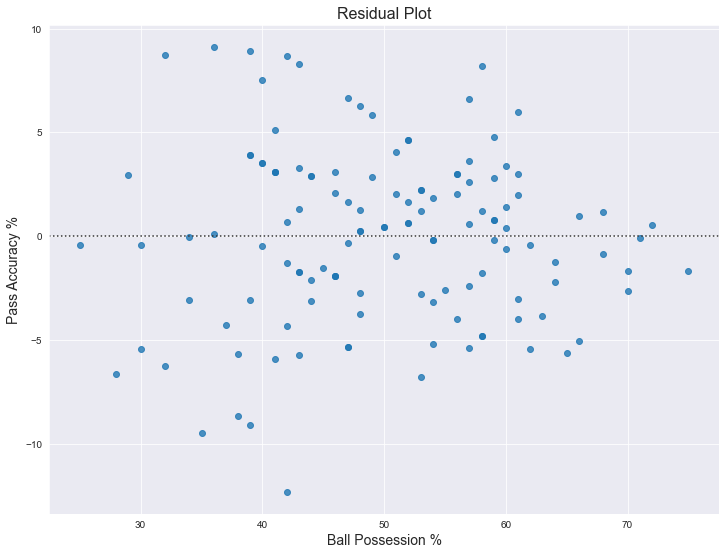

In [19]:
# Residual plot for model evaluation

plt.figure(figsize=(12, 9))
sns.residplot(data=df, x=df["Ball Possession %"], y=df["Pass Accuracy %"])
plt.xlabel("Ball Possession %", fontsize=14)
plt.ylabel("Pass Accuracy %", fontsize=14)
plt.title("Residual Plot", fontsize=16)
plt.show()

In [20]:
# Residual plots with plotly

df1 = df.ball_possession

# Split data into training and test splits
train_idx, test_idx = train_test_split(df1.index, test_size=0.25, random_state=0)
df['split'] = 'train'
df.loc[test_idx, 'split'] = 'test'

X = df['ball_possession'].values.reshape(-1, 1)
X_train = df.loc[train_idx, ['ball_possession']]
y_trian = df.loc[train_idx, ['pass_accuracy']]

# Condition the model on Ball Possession, predict the Pass Accuracy
model = LinearRegression()
model.fit(X_train, y_train)
df['prediction'] = model.predict(X)
df['residual'] = df['prediction'] - df['pass_accuracy']

fig = px.scatter(df, x='prediction', y='residual', marginal_y='violin', color='split', trendline='ols')
fig.show()

####  Observations

1. First, using numpy polyfit function, the optimal parameters, the slope and intercept, are computed. The results show that the slope is 0.4056 and the intercept is 62.2786. We then plug those values into the linear regression equation, we finally obtain the best fit regression line, Pass Accuracy (%) = 0.4056 * ball possession (%) + 62.2786 as shown above.

2. Let's plot this best fit line on the grid. I used the plotly graphing library in drawing the line since it conveniently provides the linear regression equation on the grid. If comparing the optimal parameters with each other, we confirm that those values are identical.

3. Beneath the scatterplot, we see the descriptive statistics of the linear regression model. I will simply go through 4 figures in the table.
    1. R-squared
        1. R-squared explains to what extent the variance of one variable explains the variance of the other variable. So, we see the R-squared is 0.51, meaning that 51% of the observed variation in Pass Accuray can be explained by the Ball Possession.
    2. Coefficients: constant and x1
        1. Basically, they are the optimal parameters we computed above.
        2. The constant is the intercept, and the x1 is the slope.
        3. The slope represents the mean change in the response variable for one unit of change in the predictor variable while holding other predictors in the model constant. Put it simply, the slope 0.40 means that the pass accuracy will increase by 0.40% when the ball possession increases by 1%.
    3. P-value
        1. The p-value for each parameter tests the null hypothesis that the coefficient is equal to zero (no effect). 
        2. A low p-value (< 0.05) indicates that we can reject the null hypothesis. In other words, a predictor that has a low p-value is likely to be a meaningful addition to a model because changes in the predictor's value are related to changes in the response variable.
        3. In our model, a very low p-value means that changes in Ball possession's value are related to changes in the Pass Accuracy.

4. Lastly, the residual plot is useful for evaluating the fit of a model. It seems that the values of Ball Possession between 30% and 50% have larger variance compared to the other values between 50% and 70%, but considered as a whole, we see a random scatter of points, meaning the linear regression model fits well a set of values.

#### <a href='#Table of Contents'>[Move to the Table of Contents]</a>
<a id='Prediction with linear regression'></a>
### 4) Prediction with linear regression
#### (1) Predicted output vs. Actual output

In [21]:
# Simple actual vs predicted plot

X = df['Ball Possession %'].values.reshape(-1, 1)
y = df['Pass Accuracy %']

# Condition the model on Ball Possession, predict the Pass Accuracy
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

fig = px.scatter(x=y, y=y_pred, labels={'x': 'Ground truth', 'y': 'Prediction'})
fig.add_shape(
    type="line", line=dict(dash='dash'),
    x0=y.min(), y0=y.min(),
    x1=y.max(), y1=y.max()
    )
fig.show()

This shows the simplest way to compare the predicted output vs. the actual output. A good model will have most of the scatter dots near the diagonal black line.

#### (2) Enhaned prediction error analysis

In [22]:
# Split data into training and test splits
train_idx, test_idx = train_test_split(df.index, test_size=0.25, random_state=0)
df['split'] = 'train'
df.loc[test_idx, 'split'] = 'test'

X = df['ball_possession'].values.reshape(-1, 1)
y = df['pass_accuracy']
X_train = df.loc[train_idx, 'ball_possession'].values.reshape(-1, 1)
y_train = df.loc[train_idx, 'pass_accuracy']

# Condition the model on Ball Possession, predict the Pass Accuracy
model = LinearRegression()
model.fit(X_train, y_train)
df['prediction'] = model.predict(X)

fig = px.scatter(df, x='pass_accuracy', y='prediction', marginal_x='histogram', marginal_y='histogram',
                color='split', trendline='ols')
fig.update_traces(histnorm='probability', selector={'type':'histogram'})
fig.add_shape(
    type="line", line=dict(dash='dash'),
    x0=y.min(), y0=y.min(),
    x1=y.max(), y1=y.max()
    )
fig.show()

Add marginal histograms to quickly diagnoses any prediction bias a model might have. The built-in OLS functionality  visualizes how well a model generalizes by comparing it with the theoretical optimal fit, which is a black dotted line.

#### (3) Make predictions

In [23]:
# values converts it into a numpy array
x = df["Ball Possession %"].values.reshape(-1, 1) 
 
# -1 means that calculate the dimension of rows, but have 1 column
y = df["Pass Accuracy %"].values.reshape(-1, 1)

# create object for the class
reg = LinearRegression() 

# perform linear regression
reg.fit(x, y) 

# make predictions
new_x = [[38]] # After-game ball possesison of USMNT in their first match against Ghana in 2014 World Cup
print(reg.predict(new_x))

[[77.69084578]]


#### Observations

1. Since linear regression is a basic predictive analytics technique that uses historical data to predict an output variable, let's predict the value of the pass accuracy, from any values of ball possession.
2. I found the value of the ball possession of US men's national soccer team in their first match against Ghana in 2014 World Cup, which was 38%.
3. After plugging 38% into the linear regression line, we obtain about 78% of pass accuracy. This means that a team with 38% of ball possession can predict about 78% of average pass accuracy.

#### <a href='#Table of Contents'>[Move to the Table of Contents]</a>
<a id='Linear Regression Visualization'></a>
### 5) Linear regression visualization

In [24]:
# Linear regression lines by match result

fig = px.scatter(df, x="Ball Possession %", y="Pass Accuracy %", color="Result", 
                 size="Passes", hover_name="Team", trendline="ols")
fig.show()

fig = px.scatter(df, x="Ball Possession %", y="Pass Accuracy %", color="Result", 
                 size="Passes", hover_name="Team", trendline="ols", facet_col="Result")
fig.show()

results = px.get_trendline_results(fig)
print(results)

results.px_fit_results.iloc[0].summary()

  Result                                     px_fit_results
0    win  <statsmodels.regression.linear_model.Regressio...
1   lose  <statsmodels.regression.linear_model.Regressio...
2   draw  <statsmodels.regression.linear_model.Regressio...


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                     41.44
Date:                Sun, 27 Sep 2020   Prob (F-statistic):           4.94e-08
Time:                        18:36:33   Log-Likelihood:                -144.68
No. Observations:                  51   AIC:                             293.4
Df Residuals:                      49   BIC:                             297.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         62.9003      3.244     19.393      0.000      56.382      69.418
x1             0.4016      0.062      6.437      0.000       0.276       0.527
==============================================================================
Omnibus:                        0.371   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.831   Jarque-Bera (JB):                0.210
Skew:                          -0.156   Prob(JB):                        0.900
Kurtosis:                       2.956   Cond. No.                         286.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
# Displaying PolynomialFeatures using 𝐿𝐴𝑇𝐸𝑋

def format_coefs(coefs):
    equation_list = [f"{coef}x^{i}" for i, coef in enumerate(coefs)]
    equation = "$" + " + ".join(equation_list) + "$"
    
    replace_map = {"x^0": "", "x^1": "x", '+ -': '- '}
    for old, new in replace_map.items():
        equation = equation.replace(old, new)
        
    return equation

X = df.ball_possession.values.reshape(-1, 1)
x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)

fig = px.scatter(df, x='ball_possession', y='pass_accuracy', opacity=0.65)
for degree in [1, 2, 3, 4]:
    poly = PolynomialFeatures(degree)
    poly.fit(X)
    X_poly = poly.transform(X)
    x_range_poly = poly.transform(x_range)
    
    model = LinearRegression(fit_intercept=False)
    model.fit(X_poly, df.pass_accuracy)
    y_poly = model.predict(x_range_poly)
    
    equation = format_coefs(model.coef_.round(2))
    fig.add_traces(go.Scatter(x=x_range.squeeze(), y=y_poly, name=equation))
    
fig.show()

Notice how linear regression fits a straight line. Moreover, it is possible to extend linear regression to polynomial regression by using scikit-learn's PolynomialFeatures, which fits a slope for features raised to the power of n, where n=1, 2, 3, 4 in codes above.

With Plotly, it's easy to diplay latex equations in legend and titles by simply adding $ before and after your equation. This way, we can see the coefficients that our polynomial regression fitted.

### <a href='#Table of Contents'>[Move to the Table of Contents]</a>